# 分类器的不确定度估计
---
scikit-learn接口的一个有用之处就是分类器能够给出预测的不确定度估计。一般来说，你感兴趣的不仅是分类器会预测一个测试点属于哪个类别，还包括它对这个预测的置信程度。在实践中，不同类型的错误会在现实应用中导致非常不同的结果。想象一个用于测试癌症的医疗应用。假阳性预测可能只会让患者接受额外的测试，但假阴性预测却可能导致重病没有得到治疗。scikit-learn中有两个函数可用于获取分类器的不确定度估计：decision_function和predict_proba。大多数分类器（但不是全部）都至少有其中一个函数，很多分类器两个都有。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
from sklearn.model_selection import train_test_split

import  seaborn as sns
sns.set(style = "white")

构建一个GradientBoostingClassifier分类器（同时拥有decision_function和predict_proba），查看这两个函数对一个模拟二维数据集的作用：

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)
# 为了便于说明，我们将两个类别重命名为"blue"和"red"
y_named = np.array(["blue", "red"])[y]
# 我们可以对任意个数组调用train_test_split
# 所有数组的划分方式都是一致的
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(
    X, y_named, y, random_state=0)
# 构建梯度提升模型
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 决策函数
---
对于二分类的情况，decision_function返回值的形状是(n_samples,)，为每个样本都返回一个浮点数：

In [4]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


对于类别1来说，这个值表示模型对该数据点属于“正”类的置信程度。正值表示对正类的偏好，负值表示对“反类”（其他类）的偏好：

In [5]:
# 显示decision_function的前几个元素
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [6]:
# 通过仅查看决策函数的正负号来再现预测值：
print("Thresholded decision function:\n{}".format(
    gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Thresholded decision function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


对于二分类问题，“反”类始终是classes_属性的第一个元素，“正”类是classes_的第二个元素。利用classes_属性可以完全再现predict的输出：

In [7]:
# 将布尔值True/False转换成0和1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 利用0和1作为classes_的索引
pred = gbrt.classes_[greater_zero]
# pred与gbrt.predict的输出完全相同
print("pred is equal to predictions: {}".format(
    np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


decision_function可以在任意范围取值，这取决于数据与模型参数：

In [8]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
    np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


由于可以任意缩放，因此decision_function的输出往往很难解释。

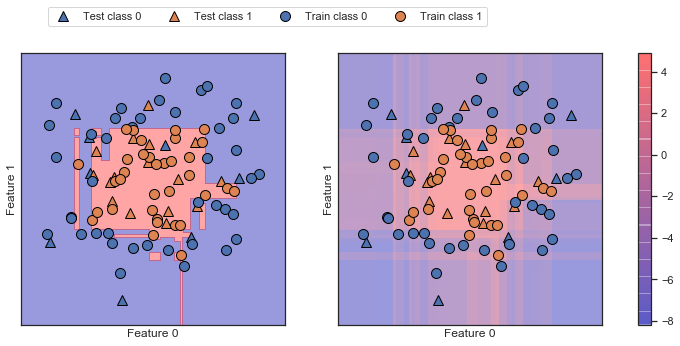

In [9]:
# 利用颜色编码在二维平面中画出所有点的决策函数及决策边界。我们将训练点画成圆，将测试数据画成三角。
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)
for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], 
                             y_test, markers='^', ax = ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], 
                             y_train, markers='o', ax = ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], 
               ncol=4, loc=(.1, 1.1))

上图为梯度提升模型在一个二维玩具数据集上的决策边界（左）和决策函数（右）。既给出预测结果，又给出分类器的置信程度，这样给出的信息量更大。但在上面的图像中，很难分辨出两个类别之间的边界。

## 预测概率
---
predict_proba的输出是每个类别的概率，通常比decision_function的输出更容易理解。对于二分类问题，它的形状始终是(n_samples, 2)：

In [10]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


每行的第一个元素是第一个类别的估计概率，第二个元素是第二个类别的估计概率。由于predict_proba的输出是一个概率，因此总是在0和1之间，两个类别的元素之和始终为1：

In [11]:
# 显示predict_proba的前几个元素
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

Predicted probabilities:
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


由于两个类别的概率之和为1，因此只有一个类别的概率超过50%。这个类别就是模型的预测结果。

在上一个输出中可以看到，分类器对大部分点的置信程度都是相对较高的。不确定度大小实际上反映了数据依赖于模型和参数的不确定度。过拟合更强的模型可能会做出置信程度更高的预测，即使可能是错的。复杂度越低的模型通常对预测的不确定度越大。如果模型给出的不确定度符合实际情况，那么这个模型被称为校正(calibrated)模型。在校正模型中，如果预测有70%的确定度，那么它在70%的情况下正确。

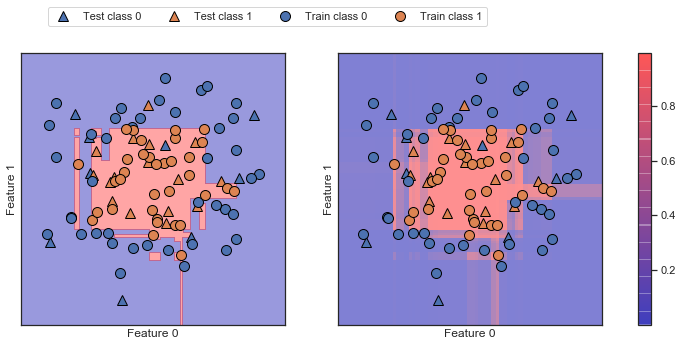

In [12]:
# 再次给出该数据集的决策边界，以及类别1的类别概率：
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function = 'predict_proba')
for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], 
                             y_test,markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], 
                             y_train,markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], 
               ncol=4, loc=(.1, 1.1))

## 多分类问题的不确定度
---
decision_function和predict_proba也适用于多分类问题。

In [13]:
# 应用于三分类鸢尾花（Iris）数据集：
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# 显示决策函数的前几个元素
print("Decision function:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function:
[[-1.9957153   0.04758118 -1.92721297]
 [ 0.0614655  -1.90755689 -1.92793177]
 [-1.99058105 -1.87637856  0.09686741]
 [-1.9957153   0.04758118 -1.92721297]
 [-1.99730166 -0.13469231 -1.20341532]
 [ 0.0614655  -1.90755689 -1.92793177]]


对于多分类的情况，decision_function的形状为(n_samples, n_classes)，每一列对应每个类别的“确定度分数”，分数较高的类别可能性更大，得分较低的类别可能性较小。你可以找出每个数据点的最大元素，从而利用这些分数再现预测结果。

In [14]:
print("Argmax of decision function:\n{}".format(
    np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


predict_proba输出的形状相同，也是(n_samples, n_classes)。同样，每个数据点所有可能类别的概率之和为1。

In [15]:
# 显示predict_proba的前几个元素
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 显示每行的和都是1
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10217734 0.78840063 0.10942203]
 [0.7834712  0.1093673  0.1071615 ]
 [0.09818079 0.11005862 0.79176059]
 [0.10217734 0.78840063 0.10942203]
 [0.10360014 0.66723882 0.22916105]
 [0.7834712  0.1093673  0.1071615 ]]
Sums: [1. 1. 1. 1. 1. 1.]


In [16]:
# 通过计算predict_proba的argmax来再现预测结果：
print("Argmax of predicted probabilities:\n{}".format(
    np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


predict_proba和decision_function的形状始终相同，都是(n_samples, n_classes)——除了二分类特殊情况下的decision_function。对于二分类的情况，decision_function只有一列，对应“正”类classes_[1]。这主要是由于历史原因。

如果有n_classes列，你可以通过计算每一列的argmax来再现预测结果。但如果类别是字符串，或者是整数，但不是从0开始的连续整数的话，一定要小心。如果你想要对比predict的结果与decision_function或predict_proba的结果，一定要用分类器的classes_属性来获取真实的属性名称：

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = "liblinear")
# 用Iris数据集的类别名称来表示每一个目标值
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format(
    logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


# 小结与展望
---
对一系列用于分类和回归的机器学习模型讨论其优点和缺点，以及如何控制它们的模型复杂度。我们发现，对于许多算法而言，设置正确的参数对模型性能至关重要。有些算法还对输入数据的表示方式很敏感，特别是特征的缩放。因此，如果盲目地将一个算法应用于数据集，而不去理解模型所做的假设以及参数设定的含义，不太可能会得到精度高的模型。

---
已学习过的基础监督学习算法总结：
* 最近邻(KNN)
--适用于小型数据集，是很好的基准模型，很容易解释。
* 线性模型(LM)
--非常可靠的首选算法，适用于非常大的数据集，也适用于高维数据。
* 朴素贝叶斯(NB)
--只适用于分类问题。比线性模型速度还快，适用于非常大的数据集和高维数据。精度通常要低于线性模型。
* 决策树(DT)
--速度很快，不需要数据缩放，可以可视化，很容易解释。
* 随机森林(RF)
--几乎总是比单棵决策树的表现要好，鲁棒性很好，非常强大。不需要数据缩放。但不适用于高维稀疏数据。
* 梯度提升决策树(GBDT)
--精度通常比随机森林略高。与随机森林相比，训练速度更慢，但预测速度更快，需要的内存也更少。比随机森林需要更多的参数调节。
* 支持向量机(SVM)
--对于特征含义相似的中等大小的数据集很强大。需要数据缩放，对参数敏感。
* 神经网络(NN)
--可以构建非常复杂的模型，特别是对于大型数据集而言。对数据缩放及参数选取敏感。大型网络需要很长的训练时间。
---
面对新数据集，通常最好先从简单模型开始，比如线性模型、朴素贝叶斯或最近邻分类器，看能得到什么样的结果。对数据有了进一步了解之后，可以考虑用于构建更复杂模型，如随机森林、梯度提升决策树、SVM或神经网络。在不同的数据集上实验各种算法，可以更好地感受它们所需的训练时间、分析模型的难易程度以及它们对数据表示的敏感程度。虽然我们分析了不同的参数设定对算法的影响，但在生产环境中实际构建一个对新数据泛化性能很好的模型要更复杂一些。